In [12]:
import pandas as pd
from pandas import json_normalize

import datetime
import numpy as np
import json
import requests
import urllib.request

from datetime import datetime
import matplotlib.pyplot as plt
from scipy import interpolate
import statsmodels.api as sm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FuncFormatter

# disaply column and row to the maximum length
#pd.set_option('display.max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

In [22]:
maturity_condition = 'days_to_maturity < 500'

url =  "https://deribit.com/api/v2/private/get_order_history_by_instrument?currency=BTC&kind=option&expired=false"
with urllib.request.urlopen(url) as url:
    get_inst_names = json.loads(url.read().decode())

inst_names = pd.DataFrame(get_inst_names['result'])#.set_index('instrument_name')
inst_names['creation_date'] = pd.to_datetime(inst_names['creation_timestamp'], unit='ms')
inst_names['expiration_date'] = pd.to_datetime(inst_names['expiration_timestamp'], unit='ms')


api_data_list = []

for x in inst_names['instrument_name']:
    url = f'https://www.deribit.com/api/v2/public/get_order_book?instrument_name={x}&kind=option&expired=false'
    with urllib.request.urlopen(url) as response:
        api_data = json.loads(response.read().decode())

    api_data_df = pd.DataFrame([api_data])
    api_data_list.append(api_data_df)

all_data = pd.concat(api_data_list, ignore_index=True)
all_data = pd.json_normalize(all_data['result'])

HTTPError: HTTP Error 400: Bad Request

In [10]:
maturity_condition = 'days_to_maturity < 500'

url =  "https://deribit.com/api/v2/public/get_instruments?currency=BTC&kind=option&expired=false"
with urllib.request.urlopen(url) as url:
    get_inst_names = json.loads(url.read().decode())

inst_names = pd.DataFrame(get_inst_names['result'])#.set_index('instrument_name')
inst_names['creation_date'] = pd.to_datetime(inst_names['creation_timestamp'], unit='ms')
inst_names['expiration_date'] = pd.to_datetime(inst_names['expiration_timestamp'], unit='ms')


api_data_list = []

for x in inst_names['instrument_name']:
    url = f'https://www.deribit.com/api/v2/public/get_order_book?instrument_name={x}&kind=option&expired=false'
    with urllib.request.urlopen(url) as response:
        api_data = json.loads(response.read().decode())

    api_data_df = pd.DataFrame([api_data])
    api_data_list.append(api_data_df)

all_data = pd.concat(api_data_list, ignore_index=True)
all_data = pd.json_normalize(all_data['result'])


KeyboardInterrupt: 

In [ ]:
exclude_columns = ['instrument_name', 'underlying_index']
all_data = all_data.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.name not in exclude_columns else x)


In [ ]:
strike = []
for index, i in enumerate(data['instrument_name']):
    i = float(i.split('-')[2])
    strike.append(i)
data["strikePx"] = strike

maturity = []
for index, i in enumerate(data['instrument_name']):
    i = i.split('-')[1]
    i = pd.to_datetime(i, unit ='ns')
    maturity.append(i)
data["maturity"] = maturity

days_to_maturity = []
for index, i in enumerate(data['maturity']):
    i = (i - datetime.today()).days
    days_to_maturity.append(i)
data["days_to_maturity"] = days_to_maturity


# Moneyness, using forward price
data['moneyness'] = data['strikePx'].astype(float)/ data['underlying_price'].astype(float)
# 'underlying price' is the price of corresponding Futures

#log Moneyness, making extreme values less extreme
#data['moneyness'] = np.log(data['strikePx'].astype(float)/ data['fwdPx'].astype(float)) 


data.loc[data['instrument_name'].str.contains('-P'), 'moneyness'] = data.loc[data['instrument_name'].str.contains('-P'), 'moneyness'] * -1

data = data.sort_values(['days_to_maturity','strikePx']).query('days_to_maturity > 0')
all_calls = data[data['instrument_name'].str.contains('-C')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')
all_puts = data[data['instrument_name'].str.contains('-P')].sort_values(['days_to_maturity', 'strikePx']).query('days_to_maturity > 0')

In [23]:
#data.to_csv('btc.csv')
data = pd.read_csv('btc.csv')

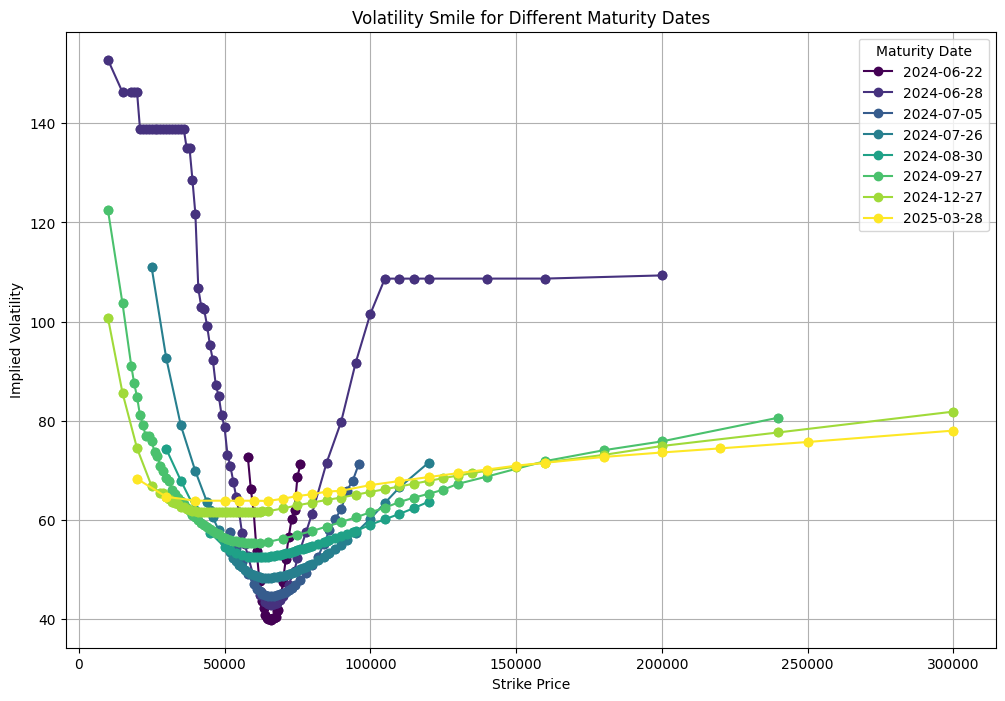

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Extract unique maturity dates
maturity_dates = data['maturity'].unique()

# Define colors for different maturities
colors = plt.cm.viridis(np.linspace(0, 1, len(maturity_dates)))

# Plotting the volatility smile for each maturity date
plt.figure(figsize=(12, 8))

for i, maturity_date in enumerate(maturity_dates):
    filtered_data = data[data['maturity'] == maturity_date]
    plt.plot(filtered_data['strikePx'], filtered_data['mark_iv'], marker='o', linestyle='-', color=colors[i], label=maturity_date)

plt.title('Volatility Smile for Different Maturity Dates')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend(title='Maturity Date')
plt.grid(True)
plt.show()


In [26]:
import pandas as pd
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# Filter the relevant columns
filtered_data = data[['strikePx', 'mark_iv', 'maturity']]

# List of unique maturity dates
maturity_dates = filtered_data['maturity'].unique()

# Create a dropdown widget for selecting maturity dates
maturity_dropdown = widgets.Dropdown(
    options=maturity_dates,
    description='Maturity:',
    disabled=False,
)

# Function to update the plot based on the selected maturity date
def update_plot(maturity):
    fig = go.Figure()
    df = filtered_data[filtered_data['maturity'] == maturity]
    fig.add_trace(go.Scatter(x=df['strikePx'], y=df['mark_iv'], mode='lines+markers', name=maturity))
    
    # Update layout for better visualization
    fig.update_layout(
        title=f'Volatility Smile for Maturity {maturity}',
        xaxis_title='Strike Price',
        yaxis_title='Implied Volatility (%)',
        template='plotly_dark'
    )
    fig.show()

# Create an interactive output widget
output = widgets.interactive_output(update_plot, {'maturity': maturity_dropdown})

# Display the widgets
display(maturity_dropdown, output)

Dropdown(description='Maturity:', options=('2024-06-22', '2024-06-28', '2024-07-05', '2024-07-26', '2024-08-30…

Output()

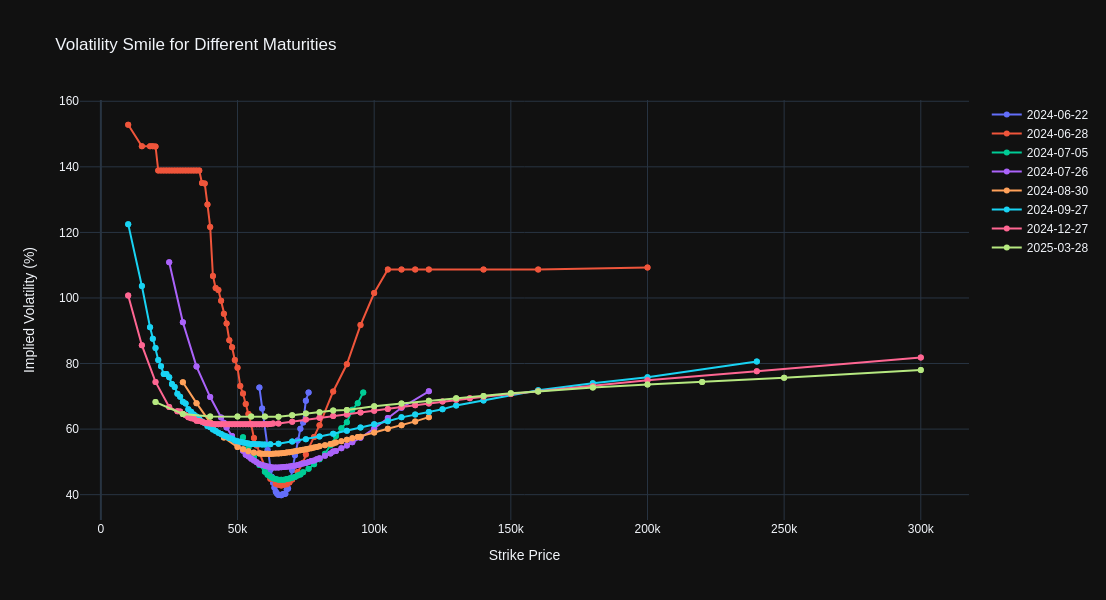

In [30]:
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display

# Filter the relevant columns
filtered_data = data[['strikePx', 'mark_iv', 'maturity']]

# List of unique maturity dates
maturity_dates = filtered_data['maturity'].unique()

# Function to update the plot
def update_plot():
    fig = go.Figure()
    
    # Add traces for each maturity date
    for maturity in maturity_dates:
        df = filtered_data[filtered_data['maturity'] == maturity]
        fig.add_trace(go.Scatter(x=df['strikePx'], y=df['mark_iv'], mode='lines+markers', name=maturity))
    
    # Update layout for better visualization
    fig.update_layout(
        title='Volatility Smile for Different Maturities',
        xaxis_title='Strike Price',
        yaxis_title='Implied Volatility (%)',
        template='plotly_dark',
        height=600  # Increase the height of the plot
    )
    fig.show()

# Display the initial plot
update_plot()
